# 亲属关系判别模型

## 一、特征工程

## 1.1 亲属称谓

In [1]:
%matplotlib  inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, auc,roc_auc_score,precision_score,accuracy_score,f1_score,recall_score,auc
def get_relative_title():
    relative_title='''父、母、大姑、二姑、三姑、姑姑、二叔、三叔、大伯、二伯、姐姐、妹、第 、
    嫂 、姐夫、妹夫、大舅、二舅、老姨、二姨、大姨、岳父、女婿、外婆、小舅、
    媳妇、宝宝、宝贝儿、老婆 、亲爱、丈母娘、
    夫亲、郎君、夫君、良人、官人、相公、老公、爱人、卿卿、外子、外人、老头子、老伴、
    娘子、内人、良人、内子、老婆、爱人、卿卿、老婆子、老伴、
    爹、爹爹、爹亲、爹地、大大、老爸、爸比、爸、老爷子、
    娘娘、娘亲、娘妮、老妈、妈咪、妈、老娘、
    哥哥、兄长、兄台、兄亲、姊长、姊台、姊亲、
    弟、兄弟、弟子、弟亲、dad、mom、
    妹、姊妹、妹子、妹亲、妈、
    儿子、囝男、宝贝、孩子、女儿、闺女、囡女、丫头、宝贝、孩子、
    嫂子、兄嫂、兄妇、兄妻、老二、
    姐夫、姊兄、姊郎、姊丈、
    弟媳妇、兄弟媳妇、弟妹、弟妇、
    儿媳妇、半女、息妇、媳妇、三婶、大娘、二婶、
    爹、丈人、岳父、泰山、大大、老爸、爸、老爷子、
    娘、丈母娘、岳母、泰水、老妈、妈、老娘、
    爹、公公、公爹、大大、老爸、爸、老爷子、太上皇、
    娘、婆母娘、婆娘、老妈、妈、老娘、
    大舅哥、大舅子、小舅弟、小舅子、姑爷、老二、老三、
    妹、姊妹、妹子、小姨妹、小姨子、
    妹夫、妹弟、妹郎、小姑夫、表哥、大姐、大哥、二哥、三哥、三姐、二姐、大姐'''
    relative_title=set([ line.strip() for line in relative_title.split('、')  if len(line)>0])
    return relative_title

def is_relatives(word):
    relative_title=get_relative_title()
    spec_cond=('老婆' in word) or ('老公' in word) or ('母' in word) or ('宝贝' in word) or ('亲爱' in word) or (word =='姐') or (word =='哥')
    for rn in relative_title:
        if rn in word and len(word)<10:
            flag=1
            break
        elif  spec_cond:
            flag=1
            break
        else:
            flag=0
    return flag

def get_relative(pdSeris):
    relative_arr=np.array([is_relatives(name)  for name in pdSeris.values])
    return relative_arr





In [2]:
rel_data=pd.read_csv('MSN/ymdh/relative_recogenition1.csv',index_col=0)
rel_data.name=rel_data.name.astype('string')
rel_data['is_rel']=get_relative(rel_data.name)   ## 亲戚为1，非亲属关系为0

/opt/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1.2 数据预处理

### 1.2.1  数据描述

In [3]:
rel_data.shape

(13018412, 75)

In [4]:
rel_data.head(3)

,number,total_frequency,total_duration,avg_duration,max_duration,min_duration,coef_var,income_total_duration,outgo_total_duration,income_total_frequency,...,workday3_engegament_ratio,workday3_avg_time,name,total_time,total_freq,total_avg_duration,time_ratio,freq_ratio,avg_ratio,is_rel
custorm_id,,,,,,,,,,,,,,,,,,,,,
1000014,13925267361,21,1425.0,67.857143,78,1,1.587638,41.0,1384.0,4,...,NaN,66.000000,韩凯,58505.0,720,81.256944,0.024357,0.029167,0.835093,0
1000014,13632595639,143,2893.0,20.230769,97,1,0.858234,1372.0,1521.0,61,...,0.313402,15.645161,爸,58505.0,720,81.256944,0.049449,0.198611,0.248973,1
1000014,13924677418,19,1130.0,59.473684,8,135,1.745039,216.0,914.0,8,...,0.556338,35.500000,何智尧深圳,58505.0,720,81.256944,0.019315,0.026389,0.731921,0


In [11]:
rel_data.total_frequency.quantile(0.4)

11.0

### 1.2.2   数据清洗
- < :去除最大的5%


###  数据观察，分布，极值情况，
- 采用log ，由于大部分都是属幂律分布，所以我们采用对数正太分布

#### (1) 去极值及缺失值

In [5]:
cond=(rel_data.total_frequency<103)&(rel_data.total_avg_duration<167.45)&(rel_data.total_duration<9200.0)&(rel_data.max_duration>11.5)\
      &(rel_data.avg_duration<250.0)&(rel_data.avg_duration>4.0)

In [6]:
rel_data=rel_data[cond]

In [8]:
rel_data.shape

(9033742, 75)

In [15]:
rel_num=rel_data[rel_data.is_rel==1].shape[0]
unrel_df=rel_data[rel_data.is_rel==0]
unrel_num=unrel_df.shape[0]
print   '亲属关系数据量：',rel_num
print   '非亲属关系数据量：',unrel_num

亲属关系数据量： 904479
非亲属关系数据量： 8129263


In [16]:
rel_data.head(3)

,number,total_frequency,total_duration,avg_duration,max_duration,min_duration,coef_var,income_total_duration,outgo_total_duration,income_total_frequency,...,workday3_engegament_ratio,workday3_avg_time,name,total_time,total_freq,total_avg_duration,time_ratio,freq_ratio,avg_ratio,is_rel
custorm_id,,,,,,,,,,,,,,,,,,,,,
1000014,13925267361,21,1425.0,67.857143,78,1,1.587638,41.0,1384.0,4,...,NaN,66.0,韩凯,58505.0,720,81.256944,0.024357,0.029167,0.835093,0
1000014,18665935907,6,324.0,54.000000,84,14,0.912057,76.0,248.0,3,...,NaN,46.0,alaxz,58505.0,720,81.256944,0.005538,0.008333,0.664559,0
1000014,13550317364,38,5071.0,133.447368,99,1,1.297207,1029.0,4042.0,14,...,NaN,393.0,小周,58505.0,720,81.256944,0.086676,0.052778,1.642289,0


In [9]:
rel_data.to_csv('MSN/ymdh/processed_data/mobi_data_net.csv')

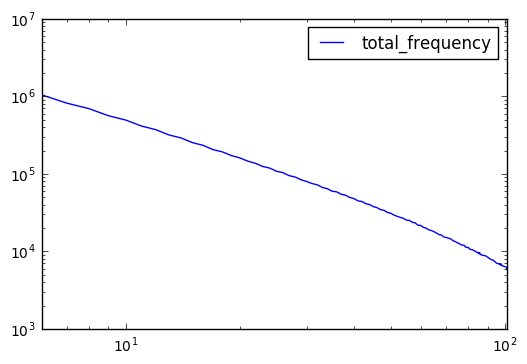

In [17]:
ax=rel_data.total_frequency.value_counts().plot(logx=True,logy=True,label='total_frequency')
ax.legend()

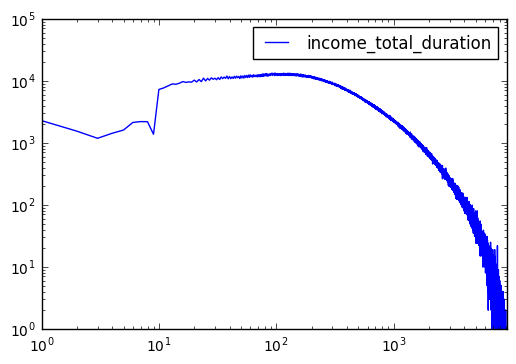

In [18]:
ax=rel_data.income_total_duration.value_counts().sort_index().plot(logx=True,logy=True,label='income_total_duration')
ax.legend()

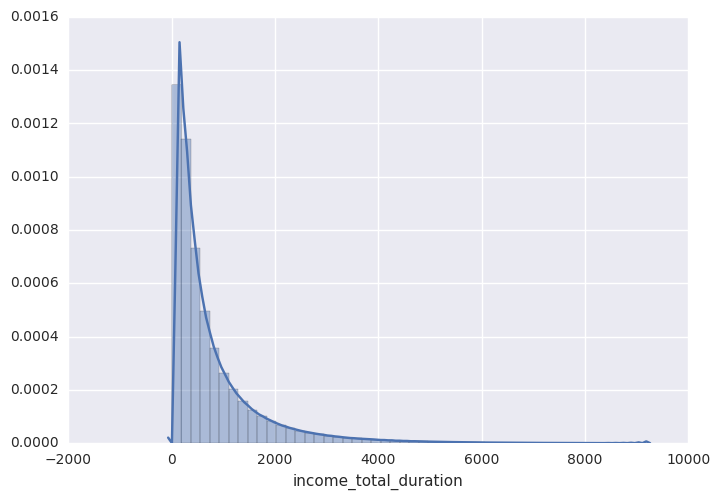

In [130]:
sns.distplot(rel_data.income_total_duration.dropna())

NameError: name 'train_data' is not defined

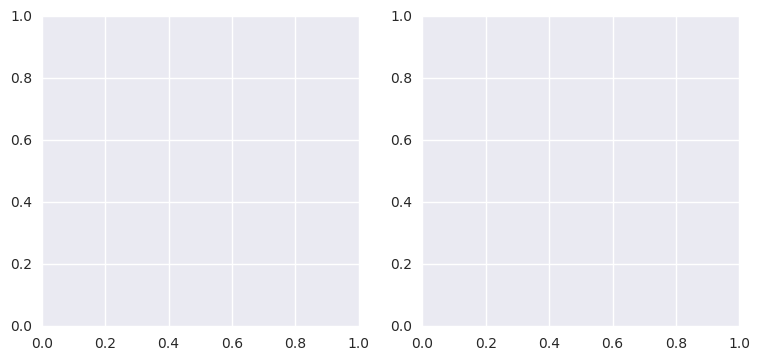

In [19]:
import seaborn  as sns  ##min_duration
label='max_duration'
fig,(ax1,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(9,4))
sns.distplot(train_data[label],ax=ax1)
sns.distplot(np.log(train_data[label]),ax=ax2)

#### （2） 采样处理数据不平衡问题

In [20]:
# 下采样（Undersampling）:对非亲属数据欠采样，使得数据保持均衡
sampler = np.random.permutation(unrel_num)[:rel_num]
unrel_df=rel_data[rel_data.is_rel==0].take(sampler)
# sampler = np.random.permutation(rel_num)[:500000]
# rel_df=rel_data[rel_data.is_rel==1].take(sampler)


### 上采样（Oversampling）：对亲属数据重采样，保持数据均衡
# sampler = np.random.randint(0,rel_num,size=unrel_num)
# rel_df=rel_data[rel_data.is_rel==1].take(sampler)

### smote算法  python

In [27]:
rel_df=rel_data[rel_data.is_rel==1]

In [31]:
# rel_df=rel_data[rel_data.is_rel==1]
# train_data=pd.concat([rel_df,unrel_df],axis=0)
train_data.drop(['number','name'],axis=1,inplace=True)

In [33]:
train_data.to_csv('MSN/result/re_data0320_180w.csv')

In [32]:
# train_data.to_csv('wyd_relative_used_data.csv')  
train_data.head(3)

,total_frequency,total_duration,avg_duration,max_duration,min_duration,coef_var,income_total_duration,outgo_total_duration,income_total_frequency,outgo_total_frequency,...,workday3_ougo_cnt,workday3_engegament_ratio,workday3_avg_time,total_time,total_freq,total_avg_duration,time_ratio,freq_ratio,avg_ratio,is_rel
custorm_id,,,,,,,,,,,,,,,,,,,,,
1000021,11,867.0,78.818182,81,12,0.824706,121.0,746.0,1,10,...,1.0,NaN,77.0,75072.0,1139,65.910448,0.011549,0.009658,1.195837,1
1000021,11,867.0,78.818182,81,12,0.824706,121.0,746.0,1,10,...,1.0,NaN,77.0,75072.0,1139,65.910448,0.011549,0.009658,1.195837,1
1000021,25,1016.0,40.640000,86,10,0.670227,136.0,880.0,4,21,...,NaN,NaN,NaN,75072.0,1139,65.910448,0.013534,0.021949,0.616594,1


#### (3) 数据标准化

In [2]:
rel_index=train_data.ix[:,['number','name','is_rel']]


In [4]:
import pandas as pd
import numpy as np
# train_data=pd.read_csv('MSN/ymdh/processed_data/mobi_data_net.csv',index_col=0)
train_data.drop(['number','name'],axis=1,inplace=True)
train_data.fillna(0.0 ,inplace=True)

In [5]:
train_data=train_data.fillna(0.0)
contact_feat=np.log(train_data.ix[:,:-1]+0.01)
target=train_data['is_rel']

In [6]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# sc = StandardScaler()
# contact_features = sc.fit_transform(contact_features)
Maxmin=MinMaxScaler()
contact_features=Maxmin.fit_transform(contact_feat)

In [7]:
rel_df=pd.DataFrame(contact_features,index=contact_feat.index,columns=contact_feat.columns)

(904479,)

In [42]:
# train_df.to_csv('MSN/result/train_df_std0320_180w.csv')

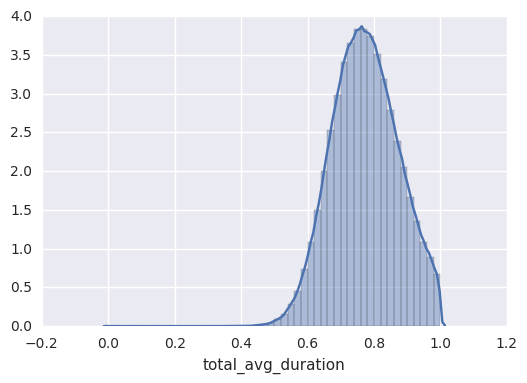

In [285]:
sns.distplot(contact_features.total_avg_duration)

## 二、模型训练

### 2.1 xgboost

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
# def modelfit(alg, dtrain,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain.values, label=target.values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
#         alg.set_params(n_estimators=cvresult.shape[0])

#     #Fit the algorithm on the data
#     alg.fit(dtrain, target,eval_metric='auc')

#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

#     #Print model report:
#     print "\nModel Report"
#     print "Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions)
#     print "AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob)

#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
# test=contact_features.ix[:,use_features]

In [30]:
from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, auc,roc_auc_score,precision_score,accuracy_score,f1_score,recall_score,auc
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV 
import gc
used_feat=pd.read_csv('feature_importance.csv',index_col=0)
use_cols=used_feat[used_feat.imv>5].index.values.astype('string')
rel_df=pd.read_csv('MSN/ymdh/processed_data/mobi_proc_data.csv',index_col=0)


target=rel_df.is_rel
rel_df1=rel_df.ix[:,:-1]
rel_df=rel_df1.ix[:,use_cols]
X_train, X_test, y_train, y_test = train_test_split(rel_df, target)
del target
del rel_df
gc.collect()
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [7]:
X_train.head(10)

,month_std_total_frequency,freq_ratio,workday2_call_cnt_ratio,avg_interval,coef_var,duration_ratio,weekend2_call_cnt_ratio,workday3_call_cnt_ratio,workday3_avg_time,month_avg_min_interval,...,weekend3_ougo_cnt_ratio,workday2_ougo_time,workday2_time,month_std_total_duration,max_aday_duration,month_avg_local_total_duration,month_avg_local_total_frequency,std_interval,week_work_ratio,month_avg_outgo2avg
custorm_id,,,,,,,,,,,,,,,,,,,,,
5845673,0.487824,0.299034,0.809696,0.829239,0.674820,0.190364,0.774140,0.725943,0.652434,0.847102,...,0.000000,0.518128,0.522148,0.557189,0.228318,0.454935,0.295373,0.873935,0.541532,0.630678
3646415,0.500247,0.187300,0.808546,0.790194,0.546555,0.236226,0.871996,0.727834,0.541232,0.507385,...,0.519216,0.600357,0.618033,0.524109,0.251561,0.591356,0.587329,0.876994,0.431083,0.642444
3110478,0.601870,0.219653,0.867796,0.742597,0.613833,0.226344,0.751370,0.530809,0.493789,0.692291,...,0.615337,0.622606,0.651501,0.561909,0.351763,0.581144,0.549942,0.822817,0.369672,0.656598
6871236,0.466168,0.176524,0.880137,0.811036,0.589660,0.234134,0.774140,0.740345,0.487877,0.793150,...,0.000000,0.598561,0.598585,0.533473,0.404582,0.553824,0.497241,0.853272,0.514864,0.620964
2473753,0.512828,0.181330,0.931034,0.775957,0.547097,0.061305,0.856101,0.449826,0.506313,0.748563,...,0.617478,0.605578,0.571651,0.500965,0.398003,0.516615,0.537565,0.807522,0.370543,0.617807
2083630,0.524330,0.066672,0.816766,0.784933,0.612739,0.145999,0.774140,0.713506,0.621050,0.800773,...,0.000000,0.633626,0.642036,0.601362,0.347942,0.610737,0.547093,0.832214,0.617261,0.635904
6103386,0.739056,0.703608,0.882639,0.620477,0.621362,0.811727,0.826671,0.868360,0.602045,0.289906,...,0.655569,0.727766,0.731600,0.698762,0.460966,0.720254,0.752847,0.702755,0.417689,0.624879
1171300,0.594511,0.201889,0.830810,0.732792,0.584227,0.199376,0.875057,0.000000,0.000000,0.726141,...,0.000000,0.618775,0.640770,0.555883,0.351071,0.585682,0.614528,0.790053,0.499414,0.648003
2178253,0.684137,0.509845,0.847921,0.640347,0.607126,0.506789,0.865610,0.812301,0.550265,0.302452,...,0.721112,0.686700,0.677309,0.632239,0.393036,0.692753,0.766562,0.689466,0.397432,0.625856


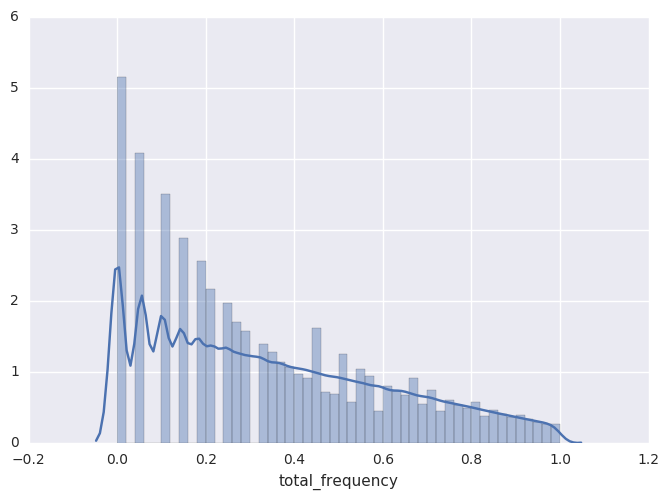

In [126]:
sns.distplot(rel_df.total_frequency)

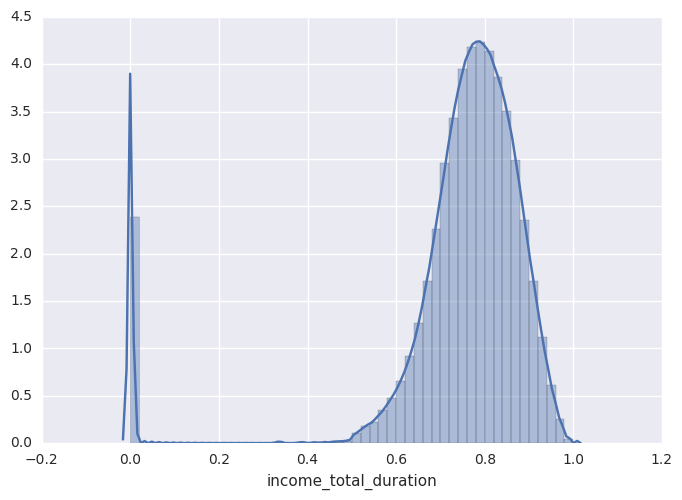

In [127]:
sns.distplot(rel_df.income_total_duration)

In [100]:
X_train.shape

(1356718, 53)

In [31]:

# xgmat = xgb.DMatrix( contact_features, label=target )
# X_train, X_test, y_train, y_test = train_test_split(contact_features, target)
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
# setup parameters for xgboost
# param = {}
# # use logistic regression loss, use raw prediction before logistic transformation
# # since we only need the rank
# param['objective'] = 'binary:logitraw'
# # scale weight of positive examples
# # param['scale_pos_weight'] = sum_wneg/sum_wpos
# param['eta'] = 0.1
# param['max_depth'] = 3
# param['eval_metric'] = 'auc'
# param['silent'] = 1
# param['nthread'] = 16
param = {'max_depth':8, 'eta':0.05, 'silent':0, 'objective':'binary:logistic'}
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [44]:
param = {'max_depth':3, 'eta':0.1, 'silent':0, 'objective':'binary:logistic'}
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [17]:
cvresult = xgb.cv(param, dtrain, nfold=5,num_boost_round=20,watchlist,metrics='error',early_stopping_rounds=50)

SyntaxError: non-keyword arg after keyword arg (<ipython-input-17-e1b7b78047df>, line 1)

In [52]:
test_erro_mean=[]
for max_depth in [3, 5,7,9, 10]:
    for lab in [1, 2, 3]:
        for min_chi  in [1,2,3,4]:
            for et  in [0.01,0.03,0.05]:
#         params = {'max_depth': max_depth, 'n_estimators': n_estimators}
                watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
                param = {'bst:max_depth':max_depth, 'bst:eta':et, 'min_child_weight':min_chi,'lambda':lab,'silent':0, 'objective':'binary:logistic' }
                plst = param.items()
                plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
                plst += [('eval_metric', 'ams@0')]
                num_round=10
                print param
                
                # gbm = xgb.train(param, dtrain, num_boost_round=30, evals=watchlist, early_stopping_rounds=100, verbose_eval=True)
                cvresult=xgb.cv(param, dtrain, num_round, nfold=5,
                       metrics={'error'}, seed = 0,early_stopping_rounds=400,
                       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
                test_erro_mean.append(cvresult['test-error-mean'].values)

{'silent': 0, 'min_child_weight': 1, 'bst:max_depth': 3, 'objective': 'binary:logistic', 'bst:eta': 0.01, 'lambda': 1}
[0]	train-error:0.36664+0.000130414	test-error:0.366819+0.00040104
[1]	train-error:0.35885+0.000515494	test-error:0.359018+0.000445798
[2]	train-error:0.354991+0.000311614	test-error:0.355067+0.000665796
[3]	train-error:0.351555+0.00040996	test-error:0.351882+0.000524372
[4]	train-error:0.34911+0.000273452	test-error:0.34941+0.000388073
[5]	train-error:0.346955+0.000229708	test-error:0.34724+0.000459493
[6]	train-error:0.344701+0.000283016	test-error:0.34501+0.00055318
[7]	train-error:0.342936+0.000264099	test-error:0.34339+0.000701224
[8]	train-error:0.341403+0.000221878	test-error:0.341893+0.000499536
[9]	train-error:0.340142+0.000202944	test-error:0.340644+0.0004416
{'silent': 0, 'min_child_weight': 1, 'bst:max_depth': 3, 'objective': 'binary:logistic', 'bst:eta': 0.03, 'lambda': 1}
[0]	train-error:0.36664+0.000130414	test-error:0.366819+0.00040104
[1]	train-error:0

KeyboardInterrupt: 

In [51]:
cvresult['test-error-mean'].values

array([ 0.3668188,  0.3590178,  0.3550674,  0.351882 ,  0.3494104,
        0.3472398,  0.3450102,  0.3433898,  0.3418926,  0.3406438,
        0.3396228,  0.3387436,  0.3379818,  0.3372652,  0.3366336,
        0.3360266,  0.3354596,  0.3349464,  0.334518 ,  0.334045 ,
        0.3335974,  0.333322 ,  0.3330554,  0.3327844,  0.3325246,
        0.3322584,  0.3319876,  0.3317548,  0.3314826,  0.331291 ,
        0.3310558,  0.3308918,  0.3306888,  0.3305482,  0.3303884,
        0.3301776,  0.3300616,  0.3299634,  0.329809 ,  0.3296598,
        0.329544 ,  0.3294184,  0.329303 ,  0.3291662,  0.3289548,
        0.3288776,  0.328746 ,  0.328665 ,  0.3285826,  0.3284826,
        0.328389 ,  0.3282838,  0.3281782,  0.3280558,  0.3279662,
        0.3278852,  0.32781  ,  0.327713 ,  0.3276456,  0.3275752,
        0.3275116,  0.327437 ,  0.3273474,  0.327277 ,  0.3272104,
        0.327119 ,  0.3270412,  0.3269854,  0.3269118,  0.3268592,
        0.3267726,  0.326713 ,  0.3266314,  0.3266044,  0.3265

In [47]:

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
param = {'bst:max_depth':6, 'bst:eta':0.01, 'silent':0, 'objective':'binary:logistic' }
plst = param.items()
plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
plst += [('eval_metric', 'error')]
num_round=20
# gbm = xgb.train(param, dtrain, num_boost_round=30, evals=watchlist, early_stopping_rounds=100, verbose_eval=True)
cvresult=xgb.cv(plst, dtrain, num_round, nfold=5,
       metrics={'error','auc'}, seed = 0,early_stopping_rounds=400,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

[0]	train-auc:0.64156+0.000158219	train-error:0.396766+0.000515337	test-auc:0.639772+0.000889078	test-error:0.397983+0.000961876
[1]	train-auc:0.648513+0.000395936	train-error:0.392135+0.000526403	test-auc:0.646266+0.000980177	test-error:0.393397+0.000939597
[2]	train-auc:0.653358+0.000239346	train-error:0.389178+0.000360289	test-auc:0.650924+0.000642904	test-error:0.390706+0.000470317
[3]	train-auc:0.656565+0.000546887	train-error:0.387066+0.000334312	test-auc:0.653895+0.000379902	test-error:0.389068+0.000423619
[4]	train-auc:0.659142+0.000416225	train-error:0.385297+0.00043017	test-auc:0.656292+0.000428768	test-error:0.387185+0.000353218
[5]	train-auc:0.661253+0.00044159	train-error:0.383758+0.000526967	test-auc:0.658126+0.000402686	test-error:0.385786+0.000519666
[6]	train-auc:0.663399+0.000493148	train-error:0.382179+0.000506353	test-auc:0.659985+0.000397661	test-error:0.384529+0.000368541
[7]	train-auc:0.665178+0.000355872	train-error:0.380872+0.000531361	test-auc:0.661403+0.00053

KeyboardInterrupt: 

In [64]:
cvresult.to_csv('MSN/ymdh/processed_data/max9_eta0.1_7500.csv')

In [85]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result
    # since preds are margin(before logistic transformation, cutoff at 0)
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

In [60]:
cvresult_erro = xgb.cv(dtrain, xgmat, nfold=5,metrics='error', early_stopping_rounds=100)

In [8]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
param = {'bst:max_depth':9, 'bst:eta':0.1,'silent':0, 'objective':'binary:logistic' }
plst = param.items()
plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
plst += [('eval_metric', 'error')]
# plst += [('eval_metric', 'evalerror')]
num_round=10000

# param = {'max_depth':7, 'eta':.0.1, 'silent':0, 'objective':'binary:logistic' }
bst=xgb.train(plst,dtrain,evals=watchlist,
              callbacks=[xgb.callback.print_evaluation(show_stdv=True)],early_stopping_rounds=7000,num_boost_round=num_round)

[0]	train-auc:0.680768	train-error:0.366336	eval-auc:0.680459	eval-error:0.366466
[0]	train-auc:0.680768	train-error:0.366336	eval-auc:0.680459	eval-error:0.366466
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 7000 rounds.
[1]	train-auc:0.691597	train-error:0.358738	eval-auc:0.691295	eval-error:0.359097
[1]	train-auc:0.691597	train-error:0.358738	eval-auc:0.691295	eval-error:0.359097
[2]	train-auc:0.697505	train-error:0.354928	eval-auc:0.697224	eval-error:0.355131
[2]	train-auc:0.697505	train-error:0.354928	eval-auc:0.697224	eval-error:0.355131
[3]	train-auc:0.702148	train-error:0.351621	eval-auc:0.701877	eval-error:0.351923
[3]	train-auc:0.702148	train-error:0.351621	eval-auc:0.701877	eval-error:0.351923
[4]	train-auc:0.705488	train-error:0.349165	eval-auc:0.705209	eval-error:0.349385
[4]	train-auc:0.705488	train-error:0.349165	eval-auc:0.705209	eval-error:0.349385
[5]	train-auc:0.708087	train-erro

In [9]:
fea_imp=pd.DataFrame(bst.get_fscore(),index=[0]).T.sort_values(0,ascending=False)

In [95]:
# fea_imp.to_csv('feature_importance.csv')
use_cols=fea_imp[fea_imp[0]>5].index.values

In [132]:
y_pred=bst.predict(dtrain)

In [17]:
fea_imp.to_csv('MSN/result/importance_score0.322.csv')

## 评价

In [26]:
xgb_model= xgb.Booster() #init model
xgb_model.load_model('MSN/result/rel_xg_0322.model') # load data

In [27]:
rel_df.head(3)

,total_frequency,total_duration,avg_duration,max_duration,min_duration,coef_var,income_total_duration,outgo_total_duration,income_total_frequency,outgo_total_frequency,...,workday3_income_cnt,workday3_ougo_cnt,workday3_engegament_ratio,workday3_avg_time,total_time,total_freq,total_avg_duration,time_ratio,freq_ratio,avg_ratio
custorm_id,,,,,,,,,,,,,,,,,,,,,
1000014,0.441995,0.684318,0.683479,0.322714,0.000000,0.764255,0.605881,0.862114,0.649383,0.805935,...,0.000000,0.671759,0.0,0.655621,0.688074,0.629208,0.853259,0.266299,0.288346,0.475259
1000014,0.000000,0.433596,0.628037,0.335494,0.339552,0.681457,0.650822,0.736905,0.618306,0.618306,...,0.524745,0.000000,0.0,0.628714,0.688074,0.629208,0.853259,0.094096,0.122118,0.440515
1000014,0.651361,0.899188,0.847641,0.363829,0.000000,0.734033,0.840582,0.940166,0.784914,0.843276,...,0.000000,0.696711,0.0,0.788611,0.688074,0.629208,0.853259,0.490814,0.391655,0.578615


In [53]:
rel1=target[target==1].index
rel1_df=rel_df.ix[rel1,:]

In [28]:

dtrain = xgb.DMatrix(rel_df, target)
y_pred=xgb_model.predict(dtrain)

In [32]:
rel_ratio=rel_df.ix[:,['avg_aday_duration','avg_duration','avg_month_engegament_ratio','avg_month_income_frequency']].sum(axis=1)

In [33]:
rel_index['rel_ratio']=rel_ratio.values/4.0

In [34]:
y_pred=rel_index.rel_ratio
d=rel_index.is_rel

In [41]:
rel_index.to_csv('MSN/result/rel_inde.csv')

In [48]:
id_num=pd.read_csv('MSN/result/id_number_0325.csv',index_col=0)
rel_index=pd.read_csv('MSN/result/rel_inde.csv')

In [113]:
id_num.head(3)
id_num['number']=id_num.number.astype(str)

In [114]:
rel_index.head(2)
rel_index['number']=rel_index.number.astype(str)

In [61]:
c=rel_index.join(id_num,on='number',how='left',rsuffix='_B')

In [119]:
c=pd.merge(rel_index,id_num,on='number',how='left')

In [121]:
d=c.dropna()

In [126]:
d=d[d.custorm_id_x!=d.custorm_id_y]

,custorm_id_x,number,name,is_rel,rel_ratio,custorm_id_y
0,1000014,13925267361,韩凯,0,0.498511,8
13,1000014,13924630605,陈建荣,0,0.538512,1164628
29,1000021,15291467200,王爸,1,0.472352,18798
36,1000021,18909168161,赵博,0,0.614376,9399774
43,1000021,18329462808,陈胜,0,0.617343,6639538
59,1000094,15770329209,杨林贵,0,0.613063,4365143
61,1000094,18787539475,花凤云,0,0.237434,5791307
65,1000109,18903123012,吴晗,0,0.659436,5621647
86,1000196,15976662707,莨少,0,0.576093,6421766
87,1000196,15976662707,唐有莨,0,0.576093,6421766


In [129]:
d.custorm_id_y=d.custorm_id_y.astype(int)


In [133]:
np.union1d(d.custorm_id_x.unique(),d.custorm_id_y.unique()).shape

(908981,)

In [111]:
id_num.number.unique()

array(['15111527555', '15030037567', '13925698548', ..., '15510856351',
       '18709263133', '15940232913'], dtype=object)

In [75]:
c.custorm_id_y=c.custorm_id_y.astype('int')

In [78]:
c.set_index('custorm_id_x').to_csv('MSN/result/rel_net0325.txt')

In [87]:
c[c.custorm_id_x!=c.custorm_id_y].set_index('custorm_id_x').drop(['name'],axis=1).to_csv('MSN/result/rel_net0325.txt')

In [11]:
bst.save_model('MSN/result/rel_xg_0322.model')

In [33]:
bst.get_score('MSN/result/featmap.txt',importance_type='cover')

{'f0': 180613.97996036967,
 'f1': 136874.4446551722,
 'f10': 169776.75159426307,
 'f11': 253068.71457961478,
 'f12': 295982.8429209187,
 'f13': 149494.71905569936,
 'f14': 121081.1384456252,
 'f15': 349299.77468196774,
 'f16': 118359.20758960837,
 'f17': 121127.39577206768,
 'f18': 125258.51678074598,
 'f19': 101132.96312777835,
 'f2': 131842.490816274,
 'f20': 160823.72615485505,
 'f21': 286256.0033213032,
 'f22': 109059.79852655808,
 'f23': 313277.26157360134,
 'f24': 216258.4719989234,
 'f25': 125149.33121923966,
 'f26': 315790.25696232275,
 'f27': 249045.826438211,
 'f28': 258864.4217415045,
 'f29': 216293.09192444952,
 'f3': 297640.4174583463,
 'f30': 114141.86191662068,
 'f31': 436729.8324134769,
 'f32': 97249.04558885944,
 'f33': 258812.0969267016,
 'f34': 97880.59218404496,
 'f35': 104022.3992383965,
 'f36': 257955.94877419292,
 'f37': 261136.8785509323,
 'f38': 132327.07699972656,
 'f39': 207008.55617861912,
 'f4': 146869.87599524893,
 'f40': 234202.29313977098,
 'f41': 136487

In [88]:
c.shape

(930620, 6)

In [15]:
bst.dump_model('MSN/result/dump.raw.txt')
bst.dump_model('dump.raw.txt',fmap='MSN/result/featmap.txt')


In [29]:
# y_pred=bst.predict(dtrain,ntree_limit=bst.best_iteration)
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0
# d=y_train
d=target
print roc_auc_score(d, y_pred)
print precision_score(d,y_pred)
print accuracy_score(d,y_pred)
print f1_score(d,y_pred)
# print recall_score(d,y_pred)


#   left  = 0.125  # the left side of the subplots of the figure
#   right = 0.9    # the right side of the subplots of the figure
#   bottom = 0.1   # the bottom of the subplots of the figure
#   top = 0.9      # the top of the subplots of the figure
#   wspace = 0.2   # the amount of width reserved for blank space between subplots
#   hspace = 0.2   # the amount of height reserved for white space between subplots

0.499970268271
0.0802949610815
0.899650886643
0.000432232170423


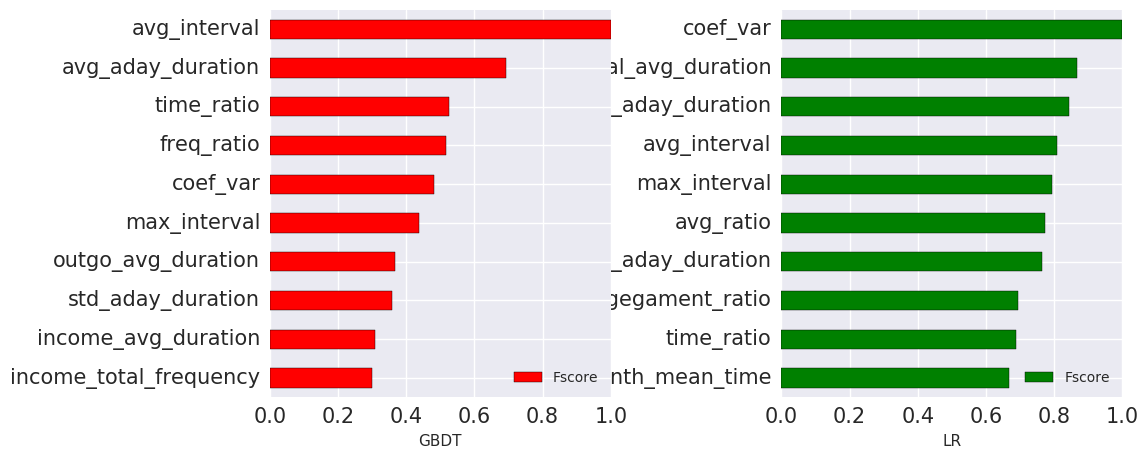

In [223]:
plt.subplot(122)
ax=(fea_imp.Fscore[:10].sort_values()/fea_imp.Fscore[:10].max()).plot.barh(color='g',figsize=(11,5),fontsize=15)
ax.legend(loc=4)
ax.set_xlabel('LR')
plt.subplot(121)

ax=(fs.Fscore[:10].sort_values()/fs.Fscore[:10].max()).plot.barh(color='red',figsize=(11,5),fontsize=15)
ax.legend(loc=4)
ax.set_xlabel('GBDT')
plt.subplots_adjust(wspace=0.5)


In [219]:
np.intersect1d(fea_imp.Fscore[:10].index,fs.Fscore[:10].index)

array(['avg_aday_duration', 'avg_interval', 'coef_var', 'max_interval',
       'std_aday_duration', 'time_ratio'], dtype=object)

In [172]:
fs=pd.read_csv('MSN/result/importance_score.csv',index_col=0)

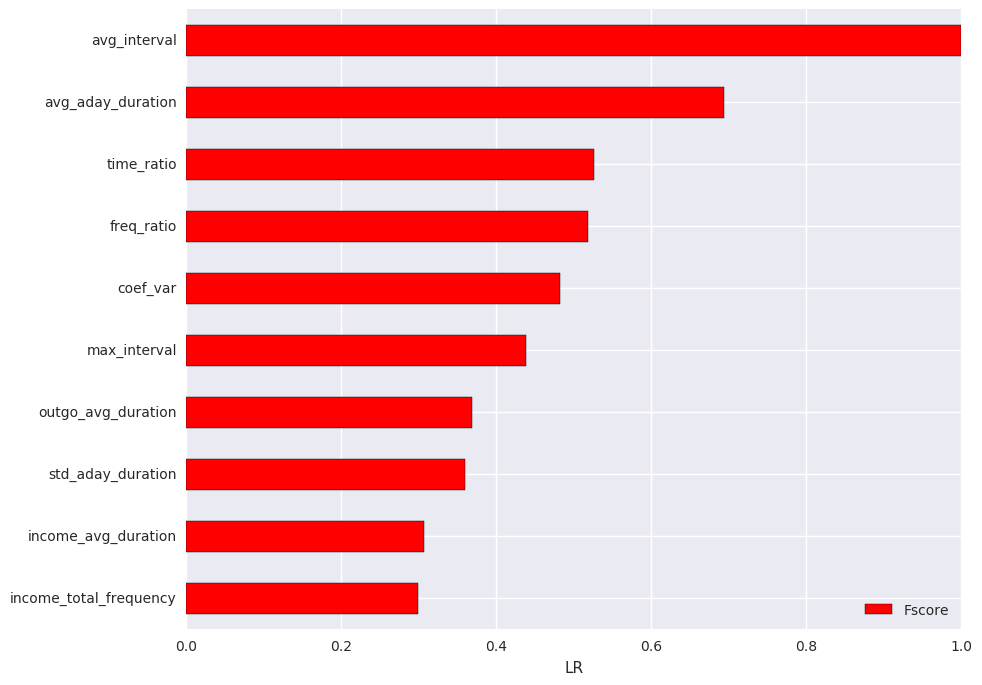

In [198]:
ax=(fs.Fscore[:10].sort_values()/fs.Fscore[:10].max()).plot.barh(color='red',figsize=(10,8))
ax.legend(loc=4)
ax.set_xlabel('LR')

In [139]:
bst.save_model('MSN/result/xgboost0321.model')

In [233]:
fs.Fscore[:10].sort_values(ascending=False)/fs.Fscore[:10].max()

avg_interval              1.000000
avg_aday_duration         0.692982
time_ratio                0.526316
freq_ratio                0.517544
coef_var                  0.482456
max_interval              0.438596
outgo_avg_duration        0.368421
std_aday_duration         0.359649
income_avg_duration       0.307018
income_total_frequency    0.298246
Name: Fscore, dtype: float64

In [232]:
fea_imp.Fscore[:10].sort_values(ascending=False)/fea_imp.Fscore[:10].max()

coef_var                      1.000000
total_avg_duration            0.866621
avg_aday_duration             0.844731
avg_interval                  0.808077
max_interval                  0.793823
avg_ratio                     0.771763
std_aday_duration             0.764297
avg_month_engegament_ratio    0.693365
time_ratio                    0.686747
month_mean_time               0.666554
Name: Fscore, dtype: float64

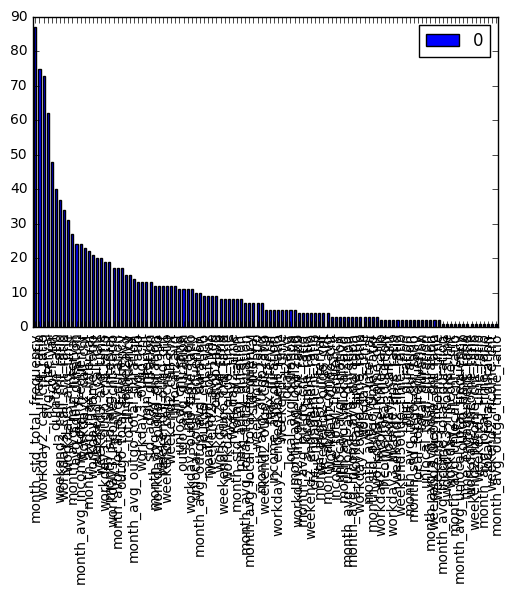

In [21]:
%matplotlib  inline
fea_imp.plot.bar()

In [128]:
feature_importance=pd.DataFrame(bst.get_score(),index=['importance']).T.sort_values('importance',ascending=False)
use_features=feature_importance.index.values[:30]

In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
param_test2 = {
'max_depth':[4,5,6],
'min_child_weight':[4,5,6],
'gamma':[i/10.0 for i in range(0,5)],
'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)],
'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.01, n_estimators=400, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1,seed=27),
 param_grid = param_test2, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
print gsearch2.grid_scores_, gsearch2.best_params_,     gsearch2.best_score_

### 2.2  SVM

In [304]:
from sklearn import svm
k=['rbf', 'linear','poly','sigmoid']
c= range(1,10)
g=np.arange(1e-4,1e-2,0.001)
g=g.tolist()
param_grid=dict(kernel=k, C=c, gamma=g)
print param_grid

svr=svm.SVC()
grid = GridSearchCV(svr, param_grid, cv=5,scoring='accuracy')
grid.fit(X_train, y_train)

# y_pre=clf.predict(X_test)
# print roc_auc_score(y_test, y_pred)
# print precision_score(y_test,y_pred)
# print accuracy_score(y_test,y_pred)
# print f1_score(y_test,y_pred)
# print recall_score(y_test,y_pred)

print("Grid scores on development set:")
print grid.grid_scores_  

print("Best parameters set found on development set:")
print(grid.best_params_)
print("Grid best score:")

print (grid.best_score_)
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores

KeyboardInterrupt: 

### 2.3 神经网络